Import everything you need

In [1]:
!pip install torchvision --quiet

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import nlp_nets as nlp
from torch import nn
import torch.optim as optim
from os.path import join as opj
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Set up seeds

In [2]:
SEED = 5
SEED = nlp.set_seed(SEED)
DEVICE = nlp.set_device()

g_seed = torch.Generator()
#g_seed.manual_seed(SEED)

Random seed 5 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Load and process data

In [23]:
# specify PATH
folder_dir = opj('/', 'Users', 'doctordu', 'Documents', 'Github', 'Neuromatch_NLP', 'dataset')

# load emotion scores
emo_arr_fake = np.load(opj(folder_dir, 'fake_emotion_array.npy'))
emo_arr_true = np.load(opj(folder_dir, 'true_emotion_array.npy'))
arr_labels = np.load(opj(folder_dir, 'labels_all.npy'))
emo_data_array = np.concatenate((emo_arr_fake, emo_arr_true))
nFeatures_emo = emo_data_array.shape[1]

# load word embeddings
embed_data_array = np.load(opj(folder_dir, 'doc2vec_embeddings_200.npy'))
nFeatures_embed = embed_data_array.shape[1]

emo_data_torch = torch.from_numpy(emo_data_array).to(DEVICE)
embed_data_torch = torch.from_numpy(embed_data_array).to(DEVICE)
labels_torch = torch.from_numpy(arr_labels).to(DEVICE)

print(nFeatures_emo)
print(nFeatures_embed)

10
200


Pack data into loaders

In [19]:
batch_size = 6000
train_size = int(0.6 * len(emo_data_torch))
val_size = int(0.2 * len(emo_data_torch))
test_size = len(emo_data_torch) - train_size - val_size


# Load emo data into loaders
emo_dataset = TensorDataset(emo_data_torch, labels_torch)
emo_train_dataset, emo_val_dataset, emo_test_dataset = random_split(emo_dataset, [train_size, val_size, test_size])

emo_test_loader = DataLoader(emo_test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=nlp.seed_worker,
                         generator=g_seed)

emo_val_loader = DataLoader(emo_val_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=nlp.seed_worker,
                          generator=g_seed)

emo_train_loader = DataLoader(emo_train_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=nlp.seed_worker,
                          generator=g_seed)


# Load embedding data into loaders
embed_dataset = TensorDataset(embed_data_torch, labels_torch)
embed_train_dataset, embed_val_dataset, embed_test_dataset = random_split(embed_dataset, [train_size, val_size, test_size])

embed_test_loader = DataLoader(embed_test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=nlp.seed_worker,
                         generator=g_seed)

embed_val_loader = DataLoader(embed_val_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=nlp.seed_worker,
                          generator=g_seed)

embed_train_loader = DataLoader(embed_train_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=0,
                          worker_init_fn=nlp.seed_worker,
                          generator=g_seed)

print(embed_dataset.tensors[0].shape)
print(emo_dataset.tensors[0].shape)

torch.Size([44265, 200])
torch.Size([44265, 10])


Run MLP on the emotion scores

Random seed 950217966 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 68.80
Accuracy on the 6000 testing samples: 69.63


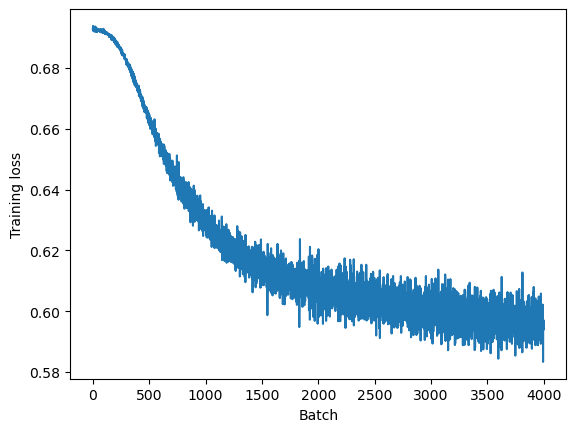

In [21]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_emo, [50], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 1000

_, _ = nlp.train_test_classification(net, criterion, optimizer, emo_train_loader,
                                 emo_val_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Run MLP on word embeddings

Random seed 219562959 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 100.00
Accuracy on the 6000 testing samples: 96.78


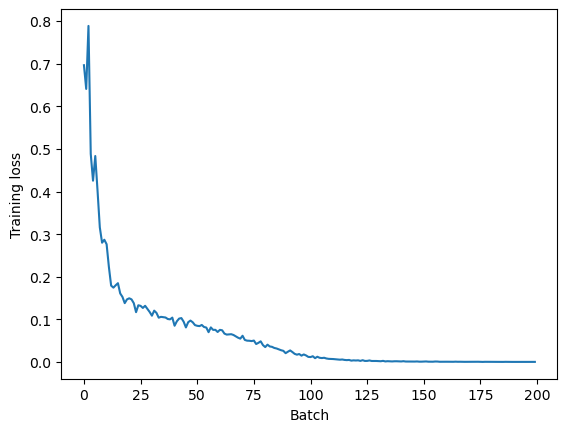

In [26]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed, [1000, 1000], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 50

_, _ = nlp.train_test_classification(net, criterion, optimizer, embed_train_loader,
                                 embed_val_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)